# Time Series Forecasting with Dart and RNN model

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional
from darts import models, backtesting
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from custom_code import sumape, create_fortnights

%matplotlib inline

In [11]:
pd.plotting.register_matplotlib_converters()


# Dart

In [12]:
df = pd.read_csv("efecty_drawdowns.csv", dtype={"y":float, "entity_id":int, "ds":str}, index_col=0)
df["ds"] = pd.to_datetime(df["ds"], format='%Y-%m-%d')
df.head()

,ds,y,entity_id
0,2019-02-05,3383730.0,995152
1,2019-02-05,988994.0,992133
2,2019-02-05,597150.0,995388
3,2019-02-05,50000.0,902343
4,2019-02-05,1426410.0,993733


In [13]:
df_995388 = df[df.entity_id == 995388]
df_995388["y"].isna().sum() 

0

In [14]:
df_995388.loc[df_995388["ds"] =="2020-01-01"]

,ds,y,entity_id


In [15]:
df_995388

,ds,y,entity_id
2,2019-02-05,597150.0,995388
355,2019-02-06,749804.0,995388
422,2019-02-07,969965.0,995388
703,2019-02-08,770000.0,995388
826,2019-02-09,621000.0,995388
...,...,...,...
72022,2020-02-25,2263630.0,995388
72235,2020-02-26,694000.0,995388
72522,2020-02-27,200000.0,995388
72931,2020-02-28,430000.0,995388


## Plot one entity

<AxesSubplot:xlabel='ds'>

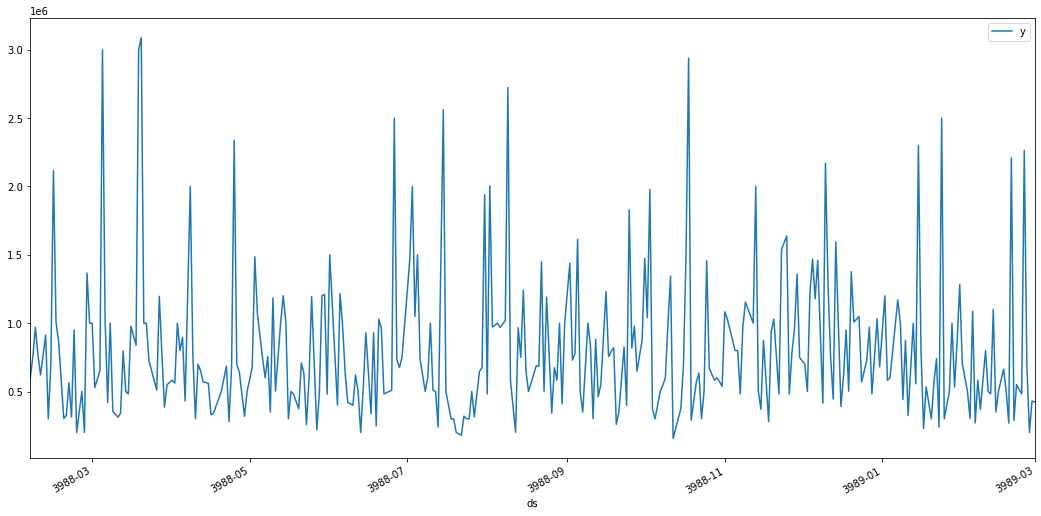

In [16]:
df_995388.plot(x="ds", y="y", figsize=(18,9))

In [17]:
df_995388.iloc[300]

ds           2020-02-08 00:00:00
y                         370000
entity_id                 995388
Name: 68468, dtype: object

## Fill missing values
TimeSeries add missing date with nan values, and you have to fillna values with `auto_fillna` function

In [18]:
date_division = "20191215"
series = TimeSeries.from_dataframe(df_995388, "ds", "y" )
series = missing_values.auto_fillna(series, method="slinear")
train, val = series.split_after(pd.Timestamp(date_division))
len(train) + len(val)

390

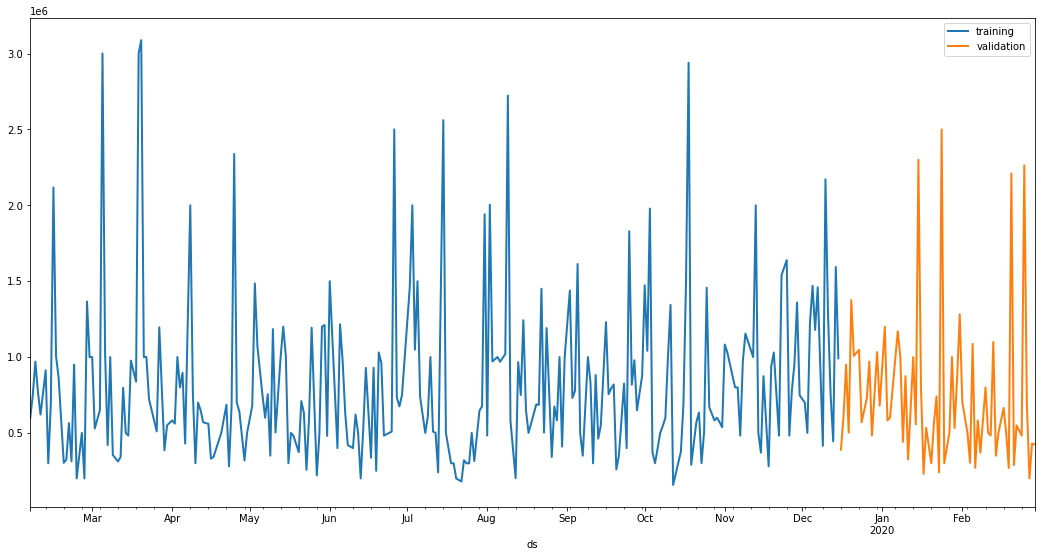

In [19]:
train.plot(lw=2, label='training', figsize=(18,9))
val.plot(lw=2, label='validation', figsize=(18,9))
plt.legend();

In [20]:
quincenas = create_fortnights(series.pd_dataframe().index[0].date(),series.pd_dataframe().index[-1].date())

## LSTM

#### Hyper-paramt

In [36]:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 15
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [37]:
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(series)

In [38]:
my_model = models.RNNModel(
    model='LSTM',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Efecty_RNN'
)

In [39]:
my_model.fit(train_transformed, val_series=val_transformed, verbose=False)

In [40]:
prediction = my_model.predict(len(val))

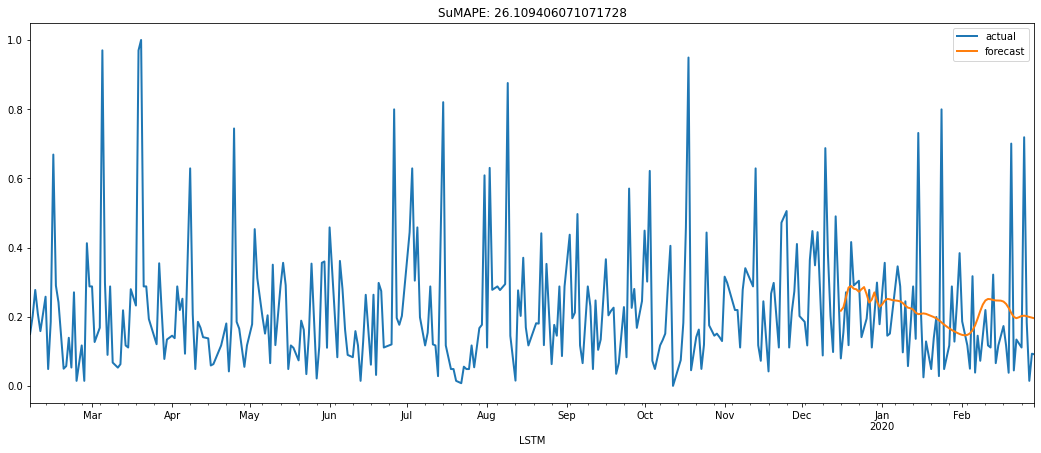

In [48]:
ts_transformed.plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("LSTM")
plt.title('SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed)))
plt.legend();

### GRU 

In [53]:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 15
# Number of features in last hidden state
HIDDEN_SIZE = 20
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [54]:
my_model_gru = models.RNNModel(
    model='GRU',
    output_length=OUTPUT_LEN,
    input_length=SEQ_LENGTH,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    batch_size=32,
    n_epochs=1000,
    model_name='Efecty_GRU',
    log_tensorboard=True
)

In [55]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.2991, validation loss: 0.2113Training loss: 0.1480, validation loss: 0.1094Training loss: 0.1452, validation loss: 0.1125Training loss: 0.1488, validation loss: 0.1142Training loss: 0.1457, validation loss: 0.1162Training loss: 0.1494, validation loss: 0.1181Training loss: 0.1501, validation loss: 0.1195Training loss: 0.1371, validation loss: 0.1217Training loss: 0.1476, validation loss: 0.1222Training loss: 0.1512, validation loss: 0.1237Training loss: 0.1347, validation loss: 0.1245Training loss: 0.1374, validation loss: 0.1237Training loss: 0.1336, validation loss: 0.1244Training loss: 0.1407, validation loss: 0.1244Training loss: 0.1331, validation loss: 0.1228Training loss: 0.1456, validation loss: 0.1230Training loss: 0.1370, validation loss: 0.1205Training loss: 0.1351, validation loss: 0.1211Training loss: 0.1464, validation loss: 0.1226Training loss: 0.1382, validation loss: 0.1220Training loss: 0.1376, validation loss: 0.1227Training loss: 0.1400, validation 

In [56]:
prediction = my_model_gru.predict(len(val))

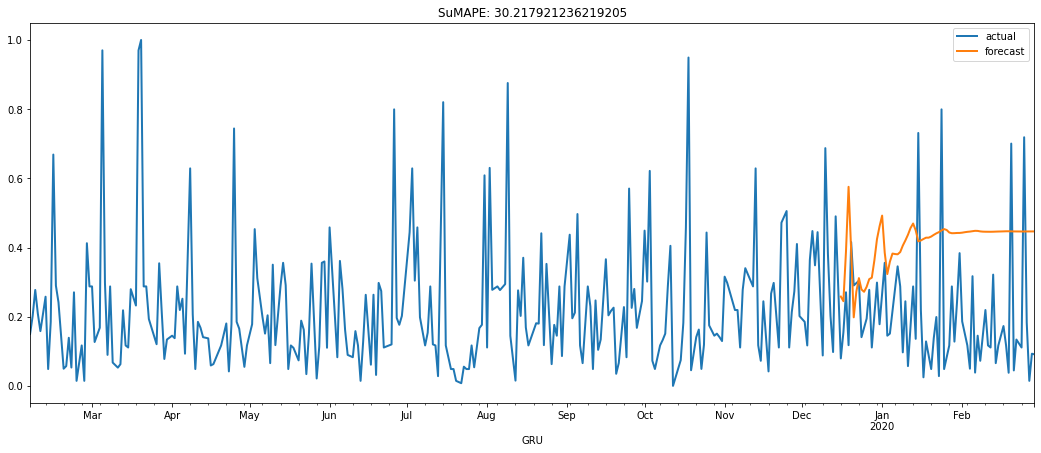

In [57]:
ts_transformed.plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("GRU")
plt.title('SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed)))
plt.legend();

## Backtesting 

In [59]:
backtest_series = backtesting.backtest_forecasting(ts_transformed, my_model, pd.Timestamp(date_division), fcast_horizon_n=15, verbose=True)

SuMAPE: 32.35%


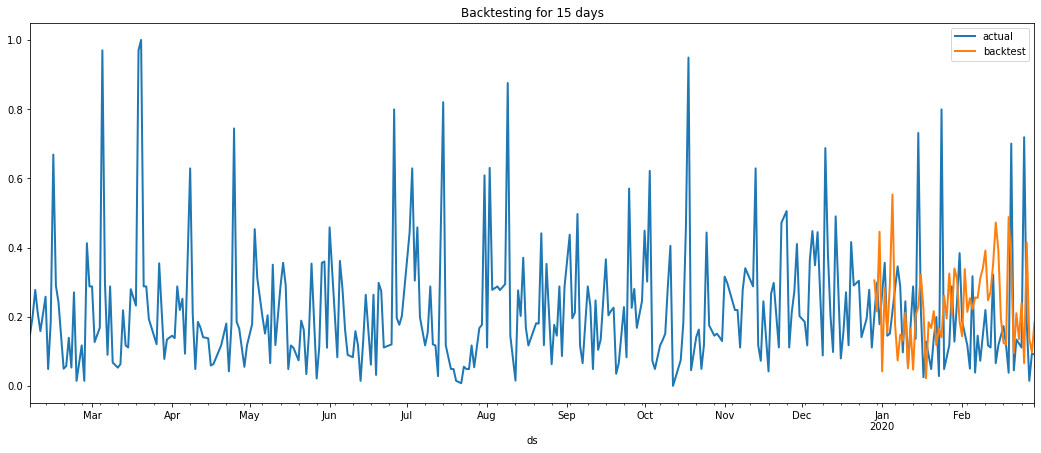

In [62]:
plt.figure(figsize=(8,5))
ts_transformed.plot(label='actual', lw=2, figsize=(18,7))
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtesting for 15 days');
print('SuMAPE: {:.2f}%'.format(sumape(transformer.inverse_transform(ts_transformed),          transformer.inverse_transform(backtest_series))))
